# Assignment 3 - Deep Learning Fundamentals
## Stock Price Prediction

Lalitphan Sae-teoh (a1932456)

Data Set : NASDAQ - NVDA price data

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM



c:\Users\lalit\anaconda3_2\envs\deep_learning\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\lalit\anaconda3_2\envs\deep_learning\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\lalit\anaconda3_2\envs\deep_learning\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\lalit\anaconda3_2\envs\deep_learni

### Data Preparation

In [2]:
file_path = "data/NASDAQ_NVDA_2014_2024.csv"
df = pd.read_csv(file_path)
df.rename(columns={'Close/Last': 'Close'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.replace('[\$]', '', regex=True).astype(float)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2024-12-04,141.995,145.79,140.290,145.14,231224300.0
2024-12-03,138.260,140.54,137.950,140.26,164414000.0
2024-12-02,138.830,140.45,137.825,138.63,171682800.0
2024-11-29,136.780,139.35,136.050,138.25,141863200.0
2024-11-27,135.010,137.22,131.800,135.34,226370900.0


In [3]:
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-12-05 to 2024-12-04
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2516 non-null   float64
 1   High    2516 non-null   float64
 2   Low     2516 non-null   float64
 3   Close   2516 non-null   float64
 4   Volume  2516 non-null   float64
dtypes: float64(5)
memory usage: 117.9 KB


In [5]:
def prepare_rnn_data(data, n_steps):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[[target_col]])

    X, y = [], []
    for i in range(len(data_scaled) - n_steps):
        X.append(data_scaled[i:i+n_steps])
        y.append(data_scaled[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 90
target_col = 'Close'

X, y = prepare_rnn_data(df, n_steps=n_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Training Set: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Test Set: {X_test.shape}, y_test shape: {y_test.shape}")

Training Set: (1940, 90, 1), y_train shape: (1940, 1)
Test Set: (486, 90, 1), y_test shape: (486, 1)


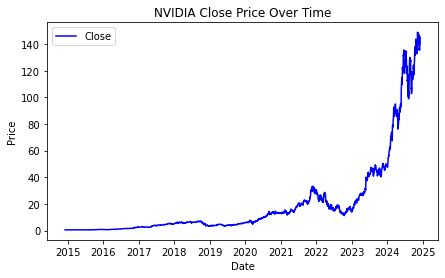

In [6]:
def plot_stock_data(df, column):
    plt.figure(figsize=(7, 4))
    plt.plot(df[column], label=column, color='blue')
    plt.title(f"NVIDIA {column} Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Plot the data
plot_stock_data(df, target_col)

### Model Implementation

#### RNN

In [7]:
# Build Vanilla RNN Model
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Define the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (n_steps, 1)
rnn_model = build_rnn_model(input_shape)

# Train the model
history = rnn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
rnn_loss, rnn_mae = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"RNN Test Loss: {rnn_loss:.4f}, Test MAE: {rnn_mae:.4f}")

# Predictions
y_pred = rnn_model.predict(X_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 1552 samples, validate on 388 samples
Epoch 1/20
1552/1552 [==============================] - 1s 700us/sample - loss: 2.3322e-04 - mean_absolute_error: 0.0076 - val_loss: 1.2318e-04 - val_mean_absolute_error: 0.0089
Epoch 2/20
1552/1552 [==============================] - 1s 563us/sample - loss: 6.0630e-06 - mean_absolute_error: 0.0016 - val_loss: 9.1149e-05 - val_mean_absolute_error: 0.0076
Epoch 3/20
1552/1552 [==============================] - 1s 607us/sample - loss: 4.6752e-06 - mean_absolute_error: 0.0014 - val_loss: 7.4086e-05 - val_mean_absolute_error: 0.0068
Epoch 4/20
1552/1552 [==============================] - 1s 528us/sample - loss: 4.3364e-06 - mean_absolute_error: 0.0014 - val_loss: 6.6929e-05 - val_mean_absolute_error: 0.0065
Epoch 5/20
1552/1552 [==============================] - 1s 737us/sample - loss: 3.8371e-06 - mean_absolute_error: 0.0012 - 

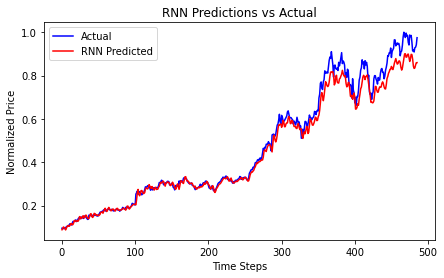

In [8]:
def plot_actual_predict(model_name, actual_data, pred_data, pred_color):
    plt.figure(figsize=(7, 4))
    plt.plot(actual_data, label='Actual', color='blue')
    plt.plot(pred_data, label=f'{model_name} Predicted', color=pred_color)
    plt.title(f"{model_name} Predictions vs Actual")
    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Price")
    plt.legend()
    plt.show()

plot_actual_predict("RNN", y_test, y_pred, "red")

#### GRU

Train on 1552 samples, validate on 388 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
1552/1552 [==============================] - 4s 3ms/sample - loss: 5.0201e-04 - mean_absolute_error: 0.0153 - val_loss: 8.2580e-05 - val_mean_absolute_error: 0.0070
Epoch 2/20
1552/1552 [==============================] - 5s 3ms/sample - loss: 5.9372e-06 - mean_absolute_error: 0.0017 - val_loss: 6.8143e-05 - val_mean_absolute_error: 0.0064
Epoch 3/20
1552/1552 [==============================] - 5s 3ms/sample - loss: 3.6449e-06 - mean_absolute_error: 0.0012 - val_loss: 7.5554e-05 - val_mean_absolute_error: 0.0067
Epoch 4/20
1552/1552 [==============================] - 6s 4ms/sample - loss: 3.6399e-06 - mean_absolute_error: 0.0012 - val_loss: 6.6484e-05 - val_mean_absolute_error: 0.0063
Epoch 5/20
1552/1552 [==============================] - 6s 4ms/sample - loss: 3.5870e-06 - mean_absolute_error: 0.0012 - val_loss: 6.5565e-05 - val_mean_ab

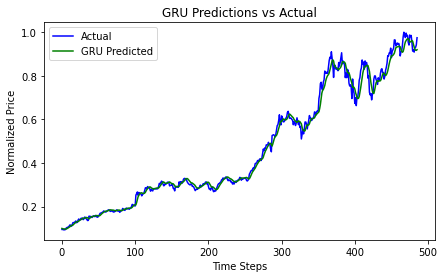

In [9]:
# Build GRU Model
def build_gru_model(input_shape):
    """Build a GRU model."""
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1) 
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

gru_model = build_gru_model(input_shape)

history_gru = gru_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

gru_loss, gru_mae = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"GRU Test Loss: {gru_loss:.4f}, Test MAE: {gru_mae:.4f}")

y_pred_gru = gru_model.predict(X_test)

plot_actual_predict("GRU", y_test, y_pred_gru, "green")

#### LSTM Model

Train on 1552 samples, validate on 388 samples
Epoch 1/20
1552/1552 [==============================] - 6s 4ms/sample - loss: 4.8214e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0012 - val_mean_absolute_error: 0.0296
Epoch 2/20
1552/1552 [==============================] - 6s 4ms/sample - loss: 1.3780e-05 - mean_absolute_error: 0.0026 - val_loss: 1.5525e-04 - val_mean_absolute_error: 0.0097
Epoch 3/20
1552/1552 [==============================] - 5s 3ms/sample - loss: 7.5764e-06 - mean_absolute_error: 0.0019 - val_loss: 1.8607e-04 - val_mean_absolute_error: 0.0106
Epoch 4/20
1552/1552 [==============================] - 5s 3ms/sample - loss: 7.5146e-06 - mean_absolute_error: 0.0018 - val_loss: 1.5594e-04 - val_mean_absolute_error: 0.0097
Epoch 5/20
1552/1552 [==============================] - 5s 3ms/sample - loss: 7.0571e-06 - mean_absolute_error: 0.0017 - val_loss: 1.6326e-04 - val_mean_absolute_error: 0.0099
Epoch 6/20
1552/1552 [==============================] - 6s 4ms/sample - loss:

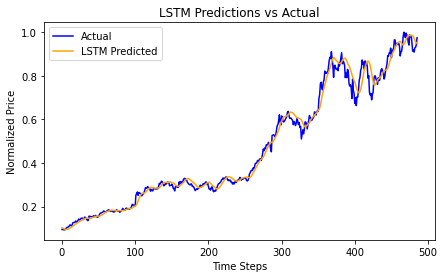

In [10]:

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

lstm_model = build_lstm_model(input_shape)

history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

lstm_loss, lstm_mae = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Test Loss: {lstm_loss:.4f}, Test MAE: {lstm_mae:.4f}")

y_pred_lstm = lstm_model.predict(X_test)

plot_actual_predict("LSTM", y_test, y_pred_lstm, "orange")

### Evaluation Performance

In [11]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate evaluation metrics and display results."""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    # print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mse, mae, rmse

def calculate_accuracy(y_true, y_pred, threshold=0.05):
    percentage_error = np.abs((y_pred - y_true) / y_true)
    accurate_predictions = np.sum(percentage_error <= threshold)
    total_predictions = len(y_true)
    return accurate_predictions / total_predictions * 100

mse_rnn, mae_rnn, rmse_rnn  = evaluate_model(y_test, y_pred, "Vanilla RNN")
mse_gru, mae_gru, rmse_gru = evaluate_model(y_test, y_pred_gru, "GRU")
mse_lstm, mae_lstm, rmse_lstm = evaluate_model(y_test, y_pred_lstm, "LSTM")

accuracy_rnn = calculate_accuracy(y_test, y_pred)
accuracy_gru = calculate_accuracy(y_test, y_pred_gru)
accuracy_lstm = calculate_accuracy(y_test, y_pred_lstm)

summary_table = pd.DataFrame({
    "Model": ["Vanilla RNN", "GRU", "LSTM"],
    "MSE": [mse_rnn, mse_gru, mse_lstm],
    "MAE": [mae_rnn, mae_gru, mae_lstm],
    "RMSE": [rmse_rnn, rmse_gru, rmse_lstm],
    "Accuracy (%)": [accuracy_rnn, accuracy_gru, accuracy_lstm]
})

print(summary_table)

         Model       MSE       MAE      RMSE  Accuracy (%)
0  Vanilla RNN  0.001573  0.025888  0.039664     62.757202
1          GRU  0.000582  0.016032  0.024118     79.218107
2         LSTM  0.000901  0.020190  0.030021     63.580247


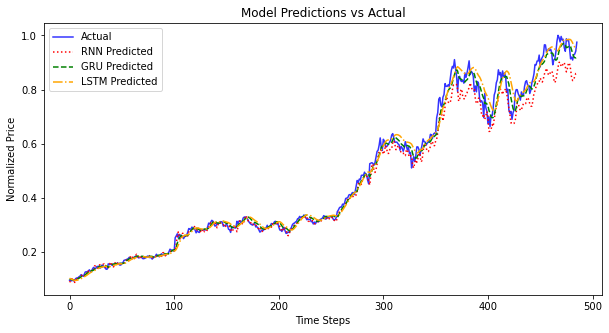

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual', color='blue', alpha=0.8)
plt.plot(y_pred, label='RNN Predicted', color='red', linestyle='dotted')
plt.plot(y_pred_gru, label='GRU Predicted', color='green', linestyle='dashed')
plt.plot(y_pred_lstm, label='LSTM Predicted', color='orange', linestyle='dashdot')
plt.title("Model Predictions vs Actual")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

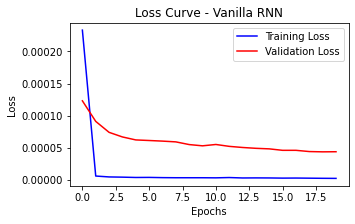

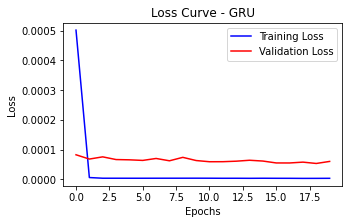

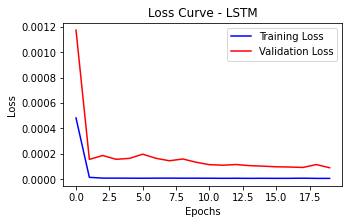

In [13]:
# Plot training and validation loss for each model
def plot_loss(history, model_name):
    """Plot training and validation loss."""
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title(f"Loss Curve - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Plot for each model
plot_loss(history, "Vanilla RNN")
plot_loss(history_gru, "GRU")
plot_loss(history_lstm, "LSTM")

### Hyperparameter Tuning on GRU

In [14]:
units_list = [16, 32, 50, 64, 128]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]

# # 3-fold cross-validation
tscv = TimeSeriesSplit(n_splits=3)  

best_config = None
best_mse = float('inf')

# Random search
n_trials = 10

for trial in range(n_trials):
    # Randomly sample hyperparameters
    units = random.choice(units_list)
    lr = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)
    print(f"Trial {trial + 1}: Units={units}, LR={lr}, Batch Size={batch_size}")

    fold_mse = []

    for train_index, val_index in tscv.split(X_train):
        # Split data into training and validation folds
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build and train model
        gru_tuning_model = Sequential([
            GRU(units, activation='tanh', input_shape=X_train_fold.shape[1:]),
            Dense(1)
        ])
        gru_tuning_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')

        gru_tuning_model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=batch_size, verbose=0)

        # Evaluate on validation fold
        y_val_pred = gru_tuning_model.predict(X_val_fold)
        fold_mse.append(mean_squared_error(y_val_fold, y_val_pred))

    # Average MSE across folds
    avg_mse = np.mean(fold_mse)
    print(f"Average MSE for Trial {trial + 1}: {avg_mse:.4f}")

    # Update best configuration
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_config = {'units': units, 'learning_rate': lr, 'batch_size': batch_size}

print(f"Best Configuration: {best_config}")
print(f"Best MSE: {best_mse:.4f}")

Trial 1: Units=50, LR=0.0001, Batch Size=16
Average MSE for Trial 1: 0.0001
Trial 2: Units=128, LR=0.001, Batch Size=16
Average MSE for Trial 2: 0.0000
Trial 3: Units=128, LR=0.0001, Batch Size=32
Average MSE for Trial 3: 0.0001
Trial 4: Units=32, LR=0.0001, Batch Size=16
Average MSE for Trial 4: 0.0001
Trial 5: Units=50, LR=0.01, Batch Size=64
Average MSE for Trial 5: 0.0002
Trial 6: Units=64, LR=0.01, Batch Size=16
Average MSE for Trial 6: 0.0000
Trial 7: Units=50, LR=0.01, Batch Size=16
Average MSE for Trial 7: 0.0000
Trial 8: Units=64, LR=0.0001, Batch Size=64
Average MSE for Trial 8: 0.0004
Trial 9: Units=32, LR=0.0001, Batch Size=16
Average MSE for Trial 9: 0.0001
Trial 10: Units=128, LR=0.001, Batch Size=32
Average MSE for Trial 10: 0.0000
Best Configuration: {'units': 64, 'learning_rate': 0.01, 'batch_size': 16}
Best MSE: 0.0000


Train on 1552 samples, validate on 388 samples
Epoch 1/20
1552/1552 [==============================] - 12s 8ms/sample - loss: 2.3349e-04 - val_loss: 3.5793e-05
Epoch 2/20
1552/1552 [==============================] - 8s 5ms/sample - loss: 2.8608e-06 - val_loss: 3.5206e-05
Epoch 3/20
1552/1552 [==============================] - 9s 6ms/sample - loss: 2.5707e-06 - val_loss: 3.5634e-05
Epoch 4/20
1552/1552 [==============================] - 8s 5ms/sample - loss: 2.8031e-06 - val_loss: 3.4598e-05
Epoch 5/20
1552/1552 [==============================] - 8s 5ms/sample - loss: 2.3896e-06 - val_loss: 4.1115e-05
Epoch 6/20
1552/1552 [==============================] - 8s 5ms/sample - loss: 2.4345e-06 - val_loss: 3.2010e-05
Epoch 7/20
1552/1552 [==============================] - 8s 5ms/sample - loss: 3.6379e-06 - val_loss: 4.0860e-05
Epoch 8/20
1552/1552 [==============================] - 8s 5ms/sample - loss: 2.6150e-06 - val_loss: 3.2272e-05
Epoch 9/20
1552/1552 [==============================] - 

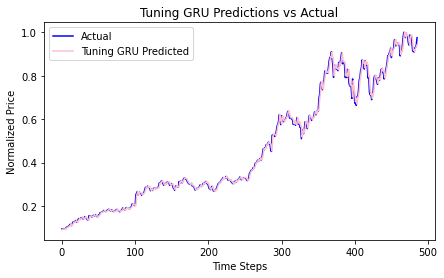

In [18]:
def build_tuning_gru_model(input_shape, units, lr):
    gru_tuning_model = Sequential([
        GRU(units, activation='tanh', input_shape=input_shape),
            Dense(1)
    ])
    gru_tuning_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return gru_tuning_model

tuning_gru_model = build_tuning_gru_model(input_shape, 64, 0.01)

history_tuning_gru = tuning_gru_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

# tuning_gru_loss, tuning_gru_mae = tuning_gru_model.evaluate(X_test, y_test, verbose=0)
# print(f"LSTM Test Loss: {tuning_gru_loss:.4f}, Test MAE: {tuning_gru_mae:.4f}")

y_pred_tuning_gru = tuning_gru_model.predict(X_test)

plot_actual_predict("Tuning GRU", y_test, y_pred_tuning_gru, "pink")

In [20]:
mse_tuning_gru, mae_tuning_gru, rmse_tuning_gru = evaluate_model(y_test, y_pred_tuning_gru, "Tuning GRU")

accuracy_tuning_gru = calculate_accuracy(y_test, y_pred_tuning_gru)

summary_table = pd.DataFrame({
    "Model": ["Vanilla RNN", "GRU", "LSTM", "Tuning GRU"],
    "MSE": [mse_rnn, mse_gru, mse_lstm, mse_tuning_gru],
    "MAE": [mae_rnn, mae_gru, mae_lstm, mae_tuning_gru],
    "RMSE": [rmse_rnn, rmse_gru, rmse_lstm, rmse_tuning_gru],
    "Accuracy (%)": [accuracy_rnn, accuracy_gru, accuracy_lstm, accuracy_tuning_gru]
})

print(summary_table)

         Model       MSE       MAE      RMSE  Accuracy (%)
0  Vanilla RNN  0.001573  0.025888  0.039664     62.757202
1          GRU  0.000582  0.016032  0.024118     79.218107
2         LSTM  0.000901  0.020190  0.030021     63.580247
3   Tuning GRU  0.000295  0.011126  0.017172     91.358025
